# Machine Learning for FPL points prediction

Below I test a variety of approaches for building a point predictor for Fantasy Premier League. I arranged the data in a "time-series fashion", where I use information available from the previous 4 gameweeks (credit to https://github.com/vaastav/Fantasy-Premier-League for the raw data).

The analysis showed that, among the ML algorithms tested, Random Forests produced the better results. This model can be used for captaincy and transfers choices, and can be easily adapted to predict points on a bigger time-window, becoming also a tool for long-term transfer planning

## Dataset

In [25]:
df = pd.read_csv(r".\complete_timeseries_dataset.csv",index_col = 0)
train = copy.deepcopy(df)

The dataset uses approximately 100 of the most popular FPL players last season.
It then creates a row for each (player, gameweek) pair, and adds information for the previous four gameweeks as explanatory variables.

Information can be roughly divided in 4 main categories:
1) Information before kick-off (which team the player is facing, how many fantasy players transferred him in/out, ...)
2) Player-specific data from previous 4 gameweeks (big chances created, points, influence, assists, ...)
3) Team specific data from previous 4 gameweeks

In [11]:
train.shape

(1856, 222)

In [13]:
print(train.columns)

Index(['name', 'team', 'position', 'gameweek', 'total_points', 'opponent_team',
       'transfers_in', 'transfers_out', 'value', 'was_home',
       ...
       '4_opp_npxGA', '4_opp_deep', '4_opp_deep_allowed', '4_opp_scored',
       '4_opp_missed', '4_opp_xpts', '4_opp_wins', '4_opp_draws',
       '4_opp_loses', '4_opp_npxGD'],
      dtype='object', length=222)


In [28]:
train.iloc[1068:1072, 0:10]

,name,team,position,gameweek,total_points,opponent_team,transfers_in,transfers_out,value,was_home
1068,Raphinha,Leeds,2.0,28,3.0,5.0,103223.0,46154.0,55.0,True
1069,Raphinha,Leeds,2.0,29,8.0,8.0,414907.0,13297.0,56.0,False
1070,Raphinha,Leeds,2.0,30,6.0,15.0,115574.0,43418.0,57.0,True
1071,Raphinha,Leeds,2.0,31,2.0,12.0,33636.0,297503.0,56.0,False


In [29]:
train.iloc[1068:1072, 10:20]

,1_total_points,1_assists,1_bonus,1_bps,1_clean_sheets,1_creativity,1_goals_conceded,1_goals_scored,1_ict_index,1_influence
1068,2.0,0.0,0.0,13.0,0.0,17.4,2.0,0.0,8.1,15.4
1069,3.0,0.0,0.0,5.0,1.0,31.1,0.0,0.0,8.9,12.8
1070,8.0,0.0,1.0,28.0,0.0,53.6,1.0,1.0,12.3,45.0
1071,6.0,1.0,1.0,24.0,0.0,43.9,1.0,0.0,12.8,35.0


In [31]:
train.iloc[1068:1072, 20:30]

,1_minutes,1_opponent_team,1_own_goals,1_penalties_missed,1_penalties_saved,1_red_cards,1_round,1_saves,1_selected,1_threat
1068,90.0,19.0,0.0,0.0,0.0,0.0,27.0,0.0,837804.0,48.0
1069,90.0,5.0,0.0,0.0,0.0,0.0,28.0,0.0,897253.0,45.0
1070,90.0,8.0,0.0,0.0,0.0,0.0,29.0,0.0,1463983.0,24.0
1071,90.0,15.0,0.0,0.0,0.0,0.0,30.0,0.0,1377968.0,49.0


In [30]:
train.iloc[1068:1072, 30:37]

,1_yellow_cards,1_goals_scored_team,1_goals_conceded_team,1_was_home,1_transfers_in,1_transfers_out,1_value
1068,0.0,0.0,2.0,False,130876.0,39272.0,54.0
1069,0.0,0.0,0.0,True,103223.0,46154.0,55.0
1070,0.0,2.0,1.0,False,414907.0,13297.0,56.0
1071,0.0,2.0,1.0,True,115574.0,43418.0,57.0


Same thing repeats for the past 4 gameweeks

There are also team-specific variables, in this case we have Leeds related xG, XG conceded etc.
For team related stats I am also using a "4 gameweek window", that is I am using all this information for the past 4 gameweeks.

In [38]:
train.iloc[1068:1072, 118:136]

,1_xG,1_xGA,1_npxG,1_npxGA,1_deep,1_deep_allowed,1_scored,1_missed,1_xpts,1_wins,1_draws,1_loses,1_npxGD,2_xG,2_xGA,2_npxG,2_npxGA,2_deep
1068,0.77074,2.506140,0.77074,1.744970,7.0,13.0,2.0,4.0,0.2415,0.0,0.0,1.0,-0.974230,2.64769,0.370278,2.64769,0.370278,7.0
1069,2.47930,0.592049,2.47930,0.592049,6.0,1.0,0.0,1.0,2.6173,0.0,0.0,1.0,1.887251,0.77074,2.506140,0.77074,1.744970,7.0
1070,1.84753,1.479810,1.84753,1.479810,10.0,5.0,3.0,0.0,1.6148,1.0,0.0,0.0,0.367720,2.47930,0.592049,2.47930,0.592049,6.0
1071,1.00106,0.876255,1.00106,0.876255,6.0,1.0,0.0,1.0,1.4385,0.0,0.0,1.0,0.124805,1.84753,1.479810,1.84753,1.479810,10.0


ofc important, who you're playing against, so I added stats of the opponent team for past 4 gwks

In [40]:
train.iloc[1068:1072, 170:185]

,1_opp_xG,1_opp_xGA,1_opp_npxG,1_opp_npxGA,1_opp_deep,1_opp_deep_allowed,1_opp_scored,1_opp_missed,1_opp_xpts,1_opp_wins,1_opp_draws,1_opp_loses,1_opp_npxGD,2_opp_xG,2_opp_xGA
1068,1.641440,0.623045,0.880268,0.623045,9,4,2,1,2.2695,1,0,0,0.257223,2.393000,0.569446
1069,0.594471,1.206420,0.594471,1.206420,4,5,1,1,0.7654,0,1,0,-0.611949,2.550850,0.314075
1070,0.977747,1.210060,0.977747,1.210060,2,7,0,1,1.1636,0,0,1,-0.232313,0.926652,2.327350
1071,0.760574,1.928920,0.760574,1.928920,5,2,2,1,0.3903,1,0,0,-1.168346,2.088680,0.331188


#### Importing relevant libraries

In [257]:
import numpy as np
import pandas as pd
import math
import random
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle


In [258]:
from sklearn.naive_bayes import GaussianNB

In [260]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn import linear_model
from sklearn.linear_model import LinearRegression


In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
from sklearn import ensemble  
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPRegressor 

### Modelling

Splittting the dataset into train and test set

In [41]:
X = pd.concat([train.iloc[:,[2]], train.iloc[:,5:]], axis = 1)
y = train.iloc[:,4]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Naive Bayes

Naive Bayes performs pretty badly due to its nature of classifier rather than regressor. Plots are given below

In [245]:
NaiveBayes = GaussianNB()

In [246]:
NaiveBayes.fit(X_train, y_train)

GaussianNB()

C:\Program Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Program Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Program Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Program Files

sqrt(MSE):  78.71336206896552


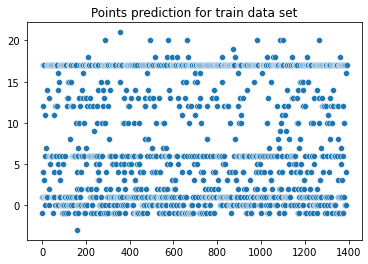

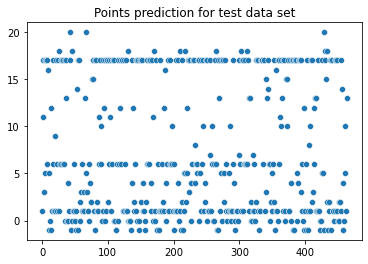

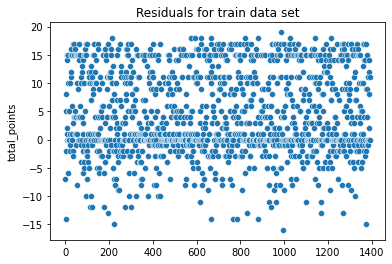

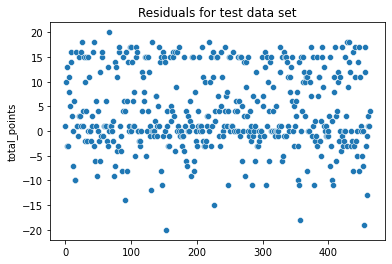

In [252]:
predict_train = NaiveBayes.predict(X_train)
predict_test = NaiveBayes.predict(X_test)

plt.figure()
sns.scatterplot(np.arange(len(y_train)), predict_train)
plt.title('Points prediction for train data set')

plt.figure()
sns.scatterplot(np.arange(len(y_test)), predict_test)
plt.title('Points prediction for test data set')

residuals = predict_train - y_train

plt.figure()
sns.scatterplot(np.arange(len(y_train)), residuals)
plt.title('Residuals for train data set')

residuals2 = predict_test - y_test
plt.figure()
sns.scatterplot(np.arange(len(y_test)), residuals2)
plt.title('Residuals for test data set')

print('sqrt(MSE): ', sum(residuals2**2)/len(residuals2))

### Regression


Creating a normalized (more precisely we make a linear transformation of the data such that it has mean 0 and variance 1)

In [53]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)   


We are now fitting a simple regression, which we aim to use as our baseline model

In [83]:
Regression = LinearRegression()

In [84]:
Regression.fit(X_train, y_train)

LinearRegression()

In [108]:
predict_train = Regression.predict(X_train)

predict_test = Regression.predict(X_test)




The overall structure of the plots of predicted values seems alright, even though at first sight it looks like too many data points are around 3 (considering that most of the players in the data set scored 100+ points)

C:\Program Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Predicted values for test set')

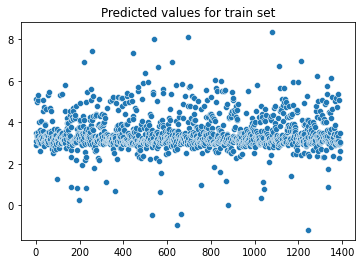

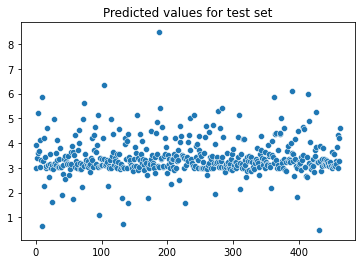

In [106]:
plt.figure()
sns.scatterplot(np.arange(len(y_train)), predict_train)
plt.title('Predicted values for train set')

plt.figure()
sns.scatterplot(np.arange(len(y_test)), predict_test)
plt.title('Predicted values for test set')

As expected there are a bunch of very negative residuals which correspond to extremely high isolated returns (13+ pts returns I'd say).

C:\Program Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Program Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.08582462203595886

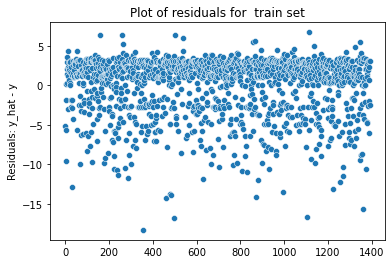

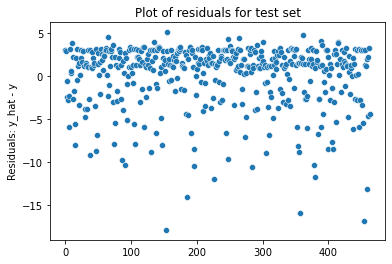

In [107]:
residuals = predict_train - y_train
plt.figure()
sns.scatterplot(np.arange(len(y_train)), residuals)
plt.ylabel('Residuals: y_hat - y')
plt.title('Plot of residuals for  train set')
residuals2 = predict_test - y_test
plt.figure()
sns.scatterplot(np.arange(len(y_test)), residuals2)
plt.ylabel('Residuals: y_hat - y')
plt.title('Plot of residuals for test set')


Let's try to use a regularization parameter (selecting it using cross-validation) to obtain better performance on the test set

In [119]:
alpha = [0.00, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000,10000000, 100000000]
mse_train = [math.nan for i in range(12)]
mse_test = [math.nan for i in range(12)]
abs_train = [math.nan for i in range(12)]
abs_test = [math.nan for i in range(12)]
for i in range(12):
    Regression = Ridge(alpha = alpha[i],fit_intercept=True, normalize=False)
    Regression.fit(X_train, y_train)
    
    predict_train = Regression.predict(X_train)

    predict_test = Regression.predict(X_test)


    residuals = predict_train - y_train

    residuals2 = predict_test - y_test
    
    mse_train[i] = np.sqrt(sum(residuals**2)/len(residuals))
    mse_test[i] = np.sqrt(sum(residuals2**2)/len(residuals2))
    
    abs_train[i] = sum(abs(residuals))/len(residuals)
    abs_test[i] = sum(abs(residuals2))/len(residuals2)
    


C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.47411e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.4648e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Text(0.5, 1.0, 'Performance on train and test set for different penalties')

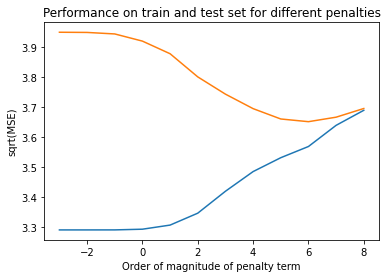

In [127]:
plt.figure()
plt.plot(np.arange(-3, -3 + len(mse_train)), mse_train)
plt.plot(np.arange(-3, -3 +len(mse_test)), mse_test)
plt.xlabel('Order of magnitude of penalty term')
plt.ylabel('sqrt(MSE)')
plt.title('Performance on train and test set for different penalties')

"Alphas" in scikit-learn are unnormalized (i.e. they are not divided by the number of observations n in the loss function), the best alpha has order of magnitude of 10^6

In [124]:
print('Unnormalized penalty alpha: ', alpha[9])
print('Normalized penalty alpha: ', alpha[9]/len(X_train))

Unnormalized penalty alpha:  1000000
Normalized penalty alpha:  718.3908045977012


Let's know fit a Ridge regression with the above penalty parameter

In [128]:
i = 9
Regression = Ridge(alpha = alpha[i],fit_intercept=True, normalize=False)
Regression.fit(X_train, y_train)
predict_train = Regression.predict(X_train)
predict_test = Regression.predict(X_test)


In [130]:
residuals = predict_train - y_train
residuals2 = predict_test - y_test
mse_train = np.sqrt(sum(residuals**2)/len(residuals))
mse_test = np.sqrt(sum(residuals2**2)/len(residuals2))
abs_train = sum(abs(residuals))/len(residuals)
abs_test = sum(abs(residuals2))/len(residuals2)

Its performance looks very solid. On average, on the test set, our predictions are off by only 2.7 points

In [131]:
print('sqrt(MSE) on train set: ', mse_train)
print('sqrt(MSE) on test set: ', mse_test)
print('Mean Absolute value of residuals on train set: ', abs_train)
print('Mean Absolute value of residuals on test set: ', abs_test)

sqrt(MSE) on train set:  3.5690746673613045
sqrt(MSE) on test set:  3.651772038360827
Mean Absolute value of residuals on train set:  2.7859636833660213
Mean Absolute value of residuals on test set:  2.735716135611483


C:\Program Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Program Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Predicted values for test set')

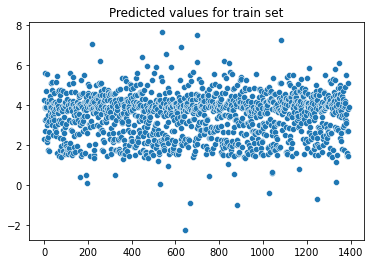

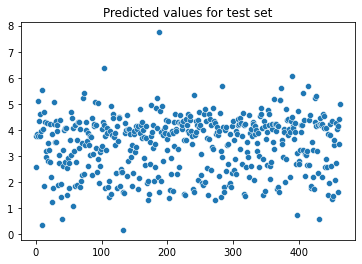

In [134]:
plt.figure()
sns.scatterplot(np.arange(len(y_train)), predict_train)
plt.title('Predicted values for train set')

plt.figure()
sns.scatterplot(np.arange(len(y_test)), predict_test)
plt.title('Predicted values for test set')

C:\Program Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Program Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Plot of residuals for test set')

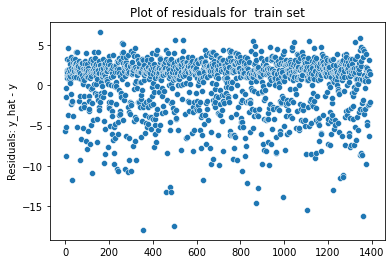

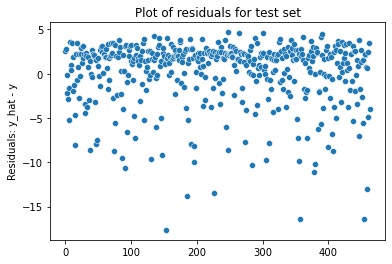

In [133]:

plt.figure()
sns.scatterplot(np.arange(len(y_train)), residuals)
plt.ylabel('Residuals: y_hat - y')
plt.title('Plot of residuals for  train set')

plt.figure()
sns.scatterplot(np.arange(len(y_test)), residuals2)
plt.ylabel('Residuals: y_hat - y')
plt.title('Plot of residuals for test set')


## Random Forest

This is the approach that gave better performance. I am including here on top the final model where I used 100000 decision trees (the rest of the the tuning turned out to be quite insignificant) 

Fitting the random forest on the training set

In [135]:
regr = RandomForestRegressor(oob_score = True, n_estimators = 100000, max_features = 5)

regr.fit(X_train, y_train)
predict_train = regr.predict(X_train)

predict_test = regr.predict(X_test)

In [138]:
out_of_bag_predict = regr.oob_score

In [139]:
residuals = predict_train - y_train
residuals2 = predict_test - y_test
residuals3 = out_of_bag_predict - y_train
mse_train = np.sqrt(sum(residuals**2)/len(residuals))
mse_test = np.sqrt(sum(residuals2**2)/len(residuals2))
mse_out_of_bag = np.sqrt(sum(residuals3**2)/len(residuals3))
abs_train = sum(abs(residuals))/len(residuals)
abs_test = sum(abs(residuals2))/len(residuals2)
abs_out_of_bag = sum(abs(residuals3))/len(residuals3)

In [146]:
print('sqrt(MSE) on train set: ', mse_train)
print('sqrt(MSE) on test set: ', mse_test)
print('Mean Absolute value of residuals on train set: ', abs_train)
print('Mean Absolute value of residuals on test set: ', abs_test)

sqrt(MSE) on train set:  1.3159610138659716
sqrt(MSE) on test set:  3.628118310324374
Mean Absolute value of residuals on train set:  1.022180926724139
Mean Absolute value of residuals on test set:  2.748467780172415


In [189]:
importances = regr.feature_importances_


The plots below show that feature importance decreses as the time distance of the gameweek increses (very natural assumption we could have made a priori).

It also shows that the model takes into account human considerations (pretty cool, right?), as it gives particular importance
to the transfers made during the week, which can be known before the gameweek deadline (which is the most significant variable of the model).

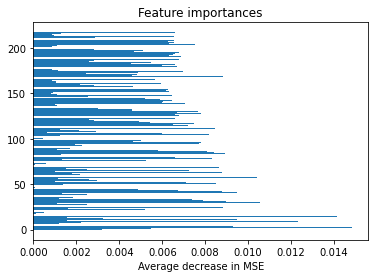

In [194]:

plt.figure()
plt.title("Feature importances")
ax = plt.barh(range(len(X_train.columns)),importances,align="center");
plt.xlabel('Average decrease in MSE');

Below are the detailed plots, for significance of the expl variables

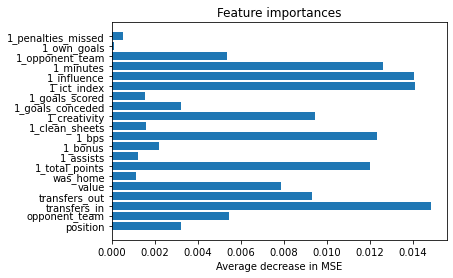

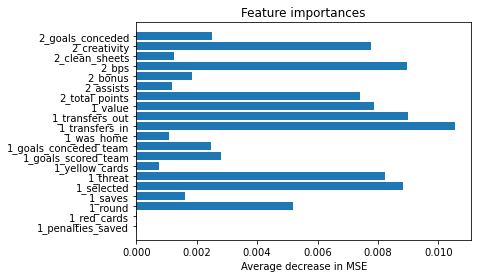

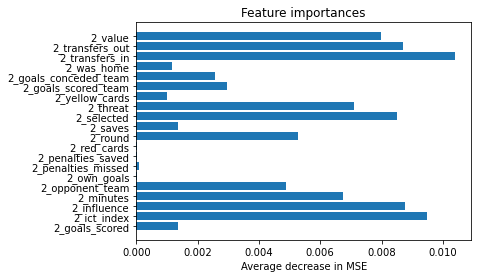

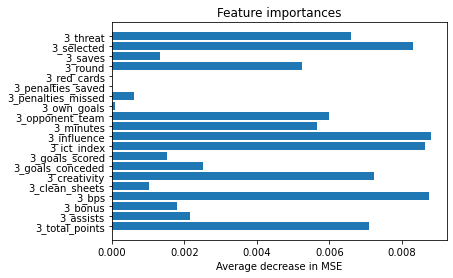

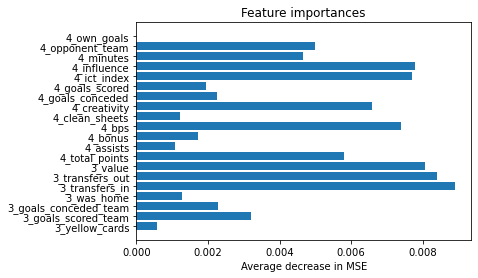

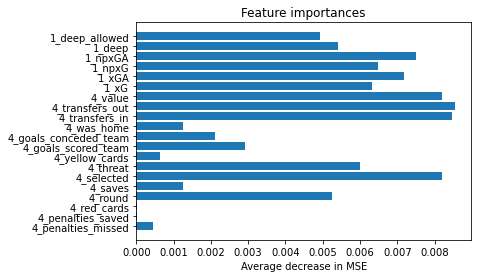

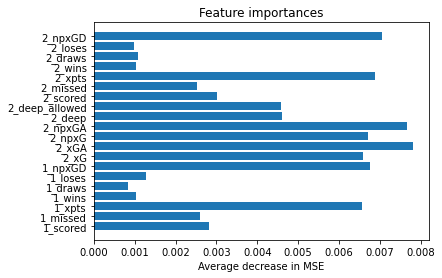

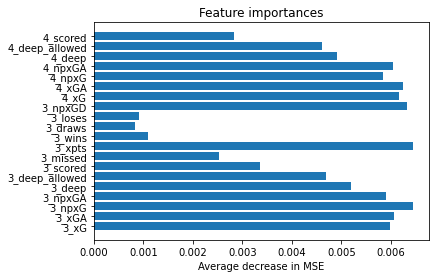

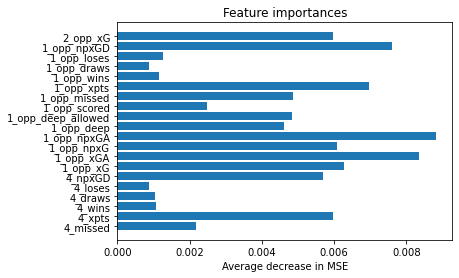

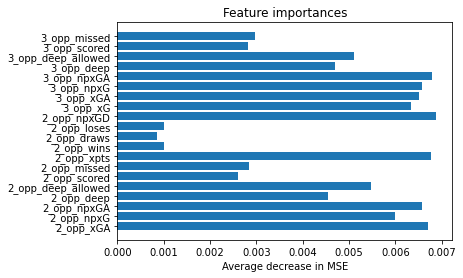

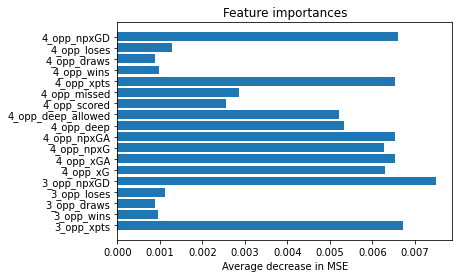

In [197]:
for i in range(0,220,20):
    plt.figure()
    plt.title("Feature importances")
    ax = plt.barh(list(X_train.columns)[i:i+20],importances[i:i+20],align="center");
    plt.xlabel('Average decrease in MSE');

#### Model parameters choice

Using cross-validation to find the optimal number of randomly sampled variables from which to find the optimal split at each node

In [166]:
features = [1,5,10,25,50,100]
n = len(features)
mse_train = [math.nan for i in range(n)]
mse_test = [math.nan for i in range(n)]
mse_out_of_bag = [math.nan for i in range(n)]
abs_train = [math.nan for i in range(n)]
abs_test = [math.nan for i in range(n)]
abs_out_of_bag = [math.nan for i in range(n)]

for i in range(n):
    Forest = RandomForestRegressor(oob_score = True, n_estimators = 1000, max_features = features[i])
    Forest.fit(X_train, y_train)
    
    predict_train = Forest.predict(X_train)

    predict_test = Forest.predict(X_test)



    
    
    
    residuals = predict_train - y_train
    residuals2 = predict_test - y_test
    residuals3 = out_of_bag_predict - y_train
    mse_train[i] = np.sqrt(sum(residuals**2)/len(residuals))
    mse_test[i] = np.sqrt(sum(residuals2**2)/len(residuals2))
    mse_out_of_bag[i] = np.sqrt(sum(residuals3**2)/len(residuals3))
    abs_train[i] = sum(abs(residuals))/len(residuals)
    abs_test[i] = sum(abs(residuals2))/len(residuals2)
    abs_out_of_bag[i] = sum(abs(residuals3))/len(residuals3)

Text(0.5, 1.0, 'number of features = [1,5,10,25,50,100]')

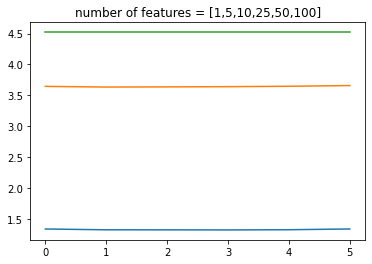

In [199]:
plt.figure()
plt.plot(np.arange(6), mse_train)
plt.plot(np.arange(6), mse_test)
plt.plot(np.arange(6), mse_out_of_bag)
plt.title('number of features = [1,5,10,25,50,100]')

We can see above that, changing the number of explanatory variables from which to sample the best split, doesn't change MSE values at all

Using cross-validation to find the optimal maximal depth of the trees on which to train the Forest

In [200]:
depth = [1,3,5,8,10,12]
n = len(depth)
mse_train = [math.nan for i in range(n)]
mse_test = [math.nan for i in range(n)]
mse_out_of_bag = [math.nan for i in range(n)]
abs_train = [math.nan for i in range(n)]
abs_test = [math.nan for i in range(n)]
abs_out_of_bag = [math.nan for i in range(n)]

for i in range(n):
    Forest = RandomForestRegressor(oob_score = True, n_estimators = 1000, max_depth = depth[i])
    Forest.fit(X_train, y_train)
    
    predict_train = Forest.predict(X_train)

    predict_test = Forest.predict(X_test)



    
    
    
    residuals = predict_train - y_train
    residuals2 = predict_test - y_test
    residuals3 = out_of_bag_predict - y_train
    mse_train[i] = np.sqrt(sum(residuals**2)/len(residuals))
    mse_test[i] = np.sqrt(sum(residuals2**2)/len(residuals2))
    mse_out_of_bag[i] = np.sqrt(sum(residuals3**2)/len(residuals3))
    abs_train[i] = sum(abs(residuals))/len(residuals)
    abs_test[i] = sum(abs(residuals2))/len(residuals2)
    abs_out_of_bag[i] = sum(abs(residuals3))/len(residuals3)

Text(0.5, 1.0, 'sqrt(MSE) for oob, test and train')

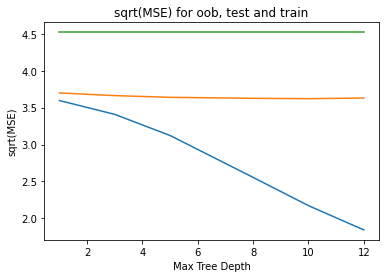

In [205]:
plt.figure()
plt.plot(depth, mse_train)
plt.plot(depth, mse_test)
plt.plot(depth, mse_out_of_bag)
plt.xlabel('Max Tree Depth')
plt.ylabel('sqrt(MSE)')
plt.title('sqrt(MSE) for oob, test and train')

We see that apart from the train MSE, which the model is overfitting, as max tree depth grows, the test set and out-of-bag predictions MSE do not improve as the depth of the trees increses

## Neural Network

Overall NNets (which peformed very well on the train set due to their extreme flexibilty), did not quite manage to perfom as well as random forests.

In my opinion, that's partly because some of the explanatory variables were catergorical, and were casted to integers.
This in not a particular problem for trees, but NNets do not capture this well.

Here, we scale the dataset, so that it is between 0 and 1 (the range of values where NNets perform best). We adopt a 6 layer network with 100 neurons at each hidden layer.

In [222]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)

neural = MLPRegressor( hidden_layer_sizes  = (100,100,100,100), max_iter = 2000, tol = 0.0001, n_iter_no_change = 10000,)


Fitting the neural network

In [170]:
neural_fit_train = neural.fit(X_train2, y_train)



C:\Program Files\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [209]:
neural_predict_train = neural.predict(X_train2)
neural_predict_test = neural.predict(X_test2)

C:\Program Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Points predicted by NNet on train set')

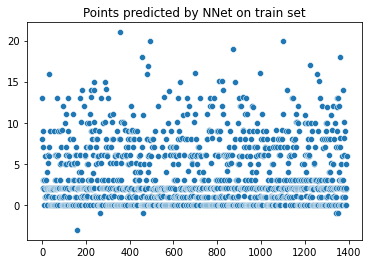

In [212]:
plt.figure()
sns.scatterplot(np.arange(len(neural_predict_train)),neural_predict_train)
plt.title('Points predicted by NNet on train set')

Looks very good (it is indeed a perfect overfit, see below)

C:\Program Files\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Points predicted by NNet on train set')

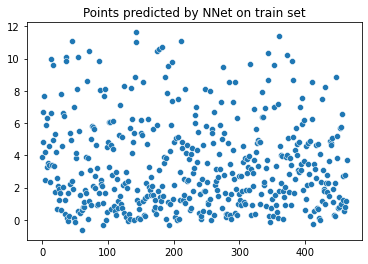

In [213]:
plt.figure()
sns.scatterplot(np.arange(len(neural_predict_test)),neural_predict_test)
plt.title('Points predicted by NNet on train set')

Test set predictions looks very reasonable

In [214]:
residuals = neural_predict_train - y_train
residuals2 = neural_predict_test - y_test
mse_train = np.sqrt(sum(residuals**2)/len(residuals))
mse_test = np.sqrt(sum(residuals2**2)/len(residuals2))
abs_train = sum(abs(residuals))/len(residuals)
abs_test = sum(abs(residuals2))/len(residuals2)

In [215]:
print('sqrt(MSE) on train set: ', mse_train)
print('sqrt(MSE) on test set: ', mse_test)
print('Mean Absolute value of residuals on train set: ', abs_train)
print('Mean Absolute value of residuals on test set: ', abs_test)

sqrt(MSE) on train set:  0.026454880764487213
sqrt(MSE) on test set:  4.252257959286345
Mean Absolute value of residuals on train set:  0.01928905836992554
Mean Absolute value of residuals on test set:  2.9892548307682256


Mad overfitting!! Performance on the test set is decent, but worse than Random Forest.

Let's do some penalization, testing different "alphas":

In [218]:
alpha = [0.00, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000,10000000, 100000000]
n = len(alpha)
mse_train = [math.nan for i in range(n)]
mse_test = [math.nan for i in range(n)]
abs_train = [math.nan for i in range(n)]
abs_test = [math.nan for i in range(n)]
for i in range(n):
    Regression = MLPRegressor(alpha = alpha[i], hidden_layer_sizes  = (100,100,100,100), 
                              max_iter = 2000, tol = 0.0001, n_iter_no_change = 10000)
    Regression.fit(X_train2, y_train)
    
    predict_train = Regression.predict(X_train2)

    predict_test = Regression.predict(X_test2)


    residuals = predict_train - y_train

    residuals2 = predict_test - y_test
    
    mse_train[i] = np.sqrt(sum(residuals**2)/len(residuals))
    mse_test[i] = np.sqrt(sum(residuals2**2)/len(residuals2))
    
    abs_train[i] = sum(abs(residuals))/len(residuals)
    abs_test[i] = sum(abs(residuals2))/len(residuals2)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Program Files\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Program Files\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Program Files\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Program Files\Anaconda3\lib\site-packages\sklearn\neural_

In [219]:
mse_train

[0.021646949856890408,
 0.002456698962901149,
 0.0656939738261973,
 0.1703294948903424,
 0.39742704287395686,
 3.795724616698754,
 3.7950105352303316,
 3.7950135119142456,
 3.794996680966512,
 3.7949971613436846,
 3.7949966659680174,
 3.79499664329127]

In [220]:
mse_test

[4.317145500429184,
 4.245255872615433,
 4.357304114833018,
 4.40810062324287,
 4.2742598003685695,
 3.819129385288484,
 3.815473836209525,
 3.81622853552618,
 3.815799042329807,
 3.8157491163574275,
 3.8158031884868477,
 3.81581632166375]

Text(0.5, 1.0, 'Performance on train and test set for different penalties')

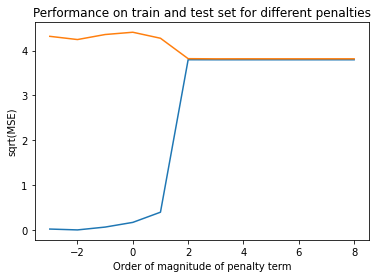

In [221]:
plt.figure()
plt.plot(np.arange(-3, -3 + len(mse_train)), mse_train)
plt.plot(np.arange(-3, -3 +len(mse_test)), mse_test)
plt.xlabel('Order of magnitude of penalty term')
plt.ylabel('sqrt(MSE)')
plt.title('Performance on train and test set for different penalties')


A penalty of 100 looks the most sensible. And MSE gets quite close to Random Forest performance

Let's try a slightly different normalization (transform dataset inearly s.t. mean = 0, variance = 1)

In [224]:
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()


In [225]:
X_train3 = scaler2.fit_transform(X_train)
X_test3 = scaler2.transform(X_test)

neural2 = MLPRegressor( hidden_layer_sizes  = (100,100,100,100), max_iter = 2000, tol = 0.0001, n_iter_no_change = 10000,)

In [226]:
neural2.fit(X_train3, y_train)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100), max_iter=2000,
             n_iter_no_change=10000)

In [227]:
neural2_predict_train = neural2.predict(X_train3)
neural2_predict_test = neural2.predict(X_test3)

In [228]:
residuals = neural2_predict_train - y_train
residuals2 = neural2_predict_test - y_test
mse_train = np.sqrt(sum(residuals**2)/len(residuals))
mse_test = np.sqrt(sum(residuals2**2)/len(residuals2))
abs_train = sum(abs(residuals))/len(residuals)
abs_test = sum(abs(residuals2))/len(residuals2)

In [229]:
print('sqrt(MSE) on train set: ', mse_train)
print('sqrt(MSE) on test set: ', mse_test)
print('Mean Absolute value of residuals on train set: ', abs_train)
print('Mean Absolute value of residuals on test set: ', abs_test)

sqrt(MSE) on train set:  0.02296912486763067
sqrt(MSE) on test set:  4.067172926804932
Mean Absolute value of residuals on train set:  0.015423636374447389
Mean Absolute value of residuals on test set:  2.859867075428439


Performance is roughly the same

In [235]:
neural3 = MLPRegressor( hidden_layer_sizes  = (100,100), max_iter = 20000, tol = 0.0001, n_iter_no_change = 10000,)


In [236]:
neural3.fit(X_train2, y_train)

MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=20000,
             n_iter_no_change=10000)

Training a smaller NN leads to worst performance

In [232]:
neural3_predict_train = neural3.predict(X_train2)
neural3_predict_test = neural3.predict(X_test2)

In [233]:
residuals = neural3_predict_train - y_train
residuals2 = neural3_predict_test - y_test
mse_train = np.sqrt(sum(residuals**2)/len(residuals))
mse_test = np.sqrt(sum(residuals2**2)/len(residuals2))
abs_train = sum(abs(residuals))/len(residuals)
abs_test = sum(abs(residuals2))/len(residuals2)

In [234]:
print('sqrt(MSE) on train set: ', mse_train)
print('sqrt(MSE) on test set: ', mse_test)
print('Mean Absolute value of residuals on train set: ', abs_train)
print('Mean Absolute value of residuals on test set: ', abs_test)

sqrt(MSE) on train set:  0.04128097245287082
sqrt(MSE) on test set:  4.595880270553968
Mean Absolute value of residuals on train set:  0.031561795680841234
Mean Absolute value of residuals on test set:  3.3630578926234658
